In [4]:
import pandas as pd
import numpy as np
from scapy.all import rdpcap, ARP
import os
from datetime import datetime
from decimal import Decimal

def extract_arp_features(pcap_file):
    """
    Извлекает признаки ARP пакетов из PCAPNG файла
    
    Args:
        pcap_file (str): Путь к PCAPNG файлу
        
    Returns:
        DataFrame: DataFrame с признаками ARP пакетов
    """
    # Читаем PCAP файл
    packets = rdpcap(pcap_file)
    
    # Список для хранения признаков
    features = []
    
    # Словарь для отслеживания ARP запросов
    arp_requests = {}
    
    for packet in packets:
        if ARP in packet:
            # Преобразуем временную метку в float
            timestamp = float(packet.time)
            
            # Извлекаем базовые признаки
            feature = {
                'timestamp': timestamp,
                'op': packet[ARP].op,  # 1 для запроса, 2 для ответа
                'src_mac': packet[ARP].hwsrc,
                'dst_mac': packet[ARP].hwdst,
                'src_ip': packet[ARP].psrc,
                'dst_ip': packet[ARP].pdst,
                'packet_length': len(packet),
                'is_request': packet[ARP].op == 1,
                'is_response': packet[ARP].op == 2
            }
            
            # Добавляем признаки для обнаружения ARP-spoofing
            if packet[ARP].op == 1:  # Если это ARP запрос
                if packet[ARP].psrc not in arp_requests:
                    arp_requests[packet[ARP].psrc] = []
                arp_requests[packet[ARP].psrc].append(timestamp)
                
                # Очищаем старые записи (старше 5 секунд)
                arp_requests[packet[ARP].psrc] = [t for t in arp_requests[packet[ARP].psrc] 
                                                if timestamp - t <= 5]
                
                feature['request_count'] = len(arp_requests[packet[ARP].psrc])
            else:
                feature['request_count'] = 0
                
            # Добавляем признаки для определения подозрительной активности
            feature['suspicious'] = (
                packet[ARP].op == 2 and  # Если это ответ
                packet[ARP].hwsrc != packet[ARP].hwdst and  # Если MAC-адреса разные
                len(arp_requests.get(packet[ARP].psrc, [])) > 0  # Если были запросы
            )
            
            features.append(feature)
    
    # Создаем DataFrame
    df = pd.DataFrame(features)
    
    # Добавляем временные признаки
    if not df.empty:
        df['time_diff'] = df['timestamp'].diff()
        df['hour'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x).hour)
        df['minute'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x).minute)
        df['second'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x).second)
    
    return df

def process_pcap_files(input_dir, output_file):
    """
    Обрабатывает все PCAPNG файлы в директории и создает CSV файл с признаками
    
    Args:
        input_dir (str): Путь к директории с PCAPNG файлами
        output_file (str): Путь к выходному CSV файлу
    """
    all_features = []
    
    for filename in os.listdir(input_dir):
        if filename.endswith('.pcapng'):
            file_path = os.path.join(input_dir, filename)
            print(f"Обработка файла: {filename}")
            
            try:
                df = extract_arp_features(file_path)
                if not df.empty:
                    all_features.append(df)
                    print(f"Успешно обработан файл: {filename}")
            except Exception as e:
                print(f"Ошибка при обработке файла {filename}: {str(e)}")
    
    if all_features:
        # Объединяем все DataFrame
        final_df = pd.concat(all_features, ignore_index=True)
        
        # Сохраняем в CSV
        final_df.to_csv(output_file, index=False)
        print(f"Признаки сохранены в файл: {output_file}")
        print(f"Всего обработано пакетов: {len(final_df)}")
    else:
        print("Не найдено признаков для сохранения")

if __name__ == "__main__":
    # Пример использования
    input_directory = r"D:\Проекты\Дипломаня работа\DoFitN\Code\DoFitN\new_code"
    output_csv = "arp.csv"
    process_pcap_files(input_directory, output_csv)

Обработка файла: arp_2000.pcapng
Успешно обработан файл: arp_2000.pcapng
Признаки сохранены в файл: arp.csv
Всего обработано пакетов: 2230


Первые 5 строк датасета:
      timestamp  op            src_mac            dst_mac       src_ip  \
0  1.737294e+09   1  00:ad:24:bf:9d:52  00:00:00:00:00:00  192.168.1.1   
1  1.737294e+09   1  00:ad:24:bf:9d:52  00:00:00:00:00:00  192.168.1.1   
2  1.737294e+09   1  00:ad:24:bf:9d:52  00:00:00:00:00:00  192.168.1.1   
3  1.737294e+09   1  00:ad:24:bf:9d:52  00:00:00:00:00:00  192.168.1.1   
4  1.737294e+09   1  00:ad:24:bf:9d:52  00:00:00:00:00:00  192.168.1.1   

         dst_ip  packet_length  is_request  is_response  request_count  \
0  192.168.1.72             42        True        False              1   
1  192.168.1.72             42        True        False              1   
2  192.168.1.72             42        True        False              1   
3  192.168.1.15             42        True        False              2   
4  192.168.1.15             42        True        False              2   

   suspicious  time_diff  hour  minute  second  
0       False        NaN    16      

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 14)             │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 15)             │           225 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 15)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 906 (3.54 KB)

 Trainable params: 906 (3.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
56/56━━━━━━━━━━━━- loss: 0.8511━━━━━━━━ 0s━━━━━72540s━━━━━━━━━━━━━━━━━561s/step - loss: 0.4315  7/56━━ 1:36━━━━━━━━━━━━━━━━━━━ ━━ 29ms/step - loss: 0.52951s━━━━━━━━━━━━━━━━━━ 910/5611/561s━13/  24ms/step - loss: 0.6440 15/5  ━━━━━━━━━━━━━━━━━━━━━18/56━━━━━19/56 22ms/step - loss: 0.6670━━━━━━━  20/56 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0s23/56 ━━━━━━25/5624/560s  ━━━━━━━━━━━━  17ms/step - loss: 0.7003━━━━━━━26/56 0s0s27/5 18ms/step - loss: 0.7073━━━━━━━━━━━━━━0s 30/5━━━━━━━━━━━━━━━━━━━━━ ━━━━━━━━━  14ms/step - loss: 0.744━━━━━━━━━ 13ms/step - loss: 0.7612 13ms/step - loss: 0.77520s━━━━━━━━━━33/56    34/56 35/━━━━━━━━━━━  ━━━━━━━━━━ 13ms/step - loss: 0.78930s━━━━━━━━━━━━━━━━━━   13ms/step - loss: 0.8106━━━━━━━━━━38/56 13ms/step - loss: 0.8005 13ms/step - loss: 0.8194━━━━━━━━━━━━━━━━━━━━━━39/  12ms/step - loss: 0.8269━━━━━━━━━━━━━━━━━━━━━━━━ 12ms/step - loss: 0.8339━━━━━━━━━0s━━━━━━━━━━━━  ━━━━━━━━━43/56━━━━━━━━━ 42/56━━━━━━━━41/56━━━━━━━━ 0s ━━━━━━━━━━━━━0s 12ms/step - l

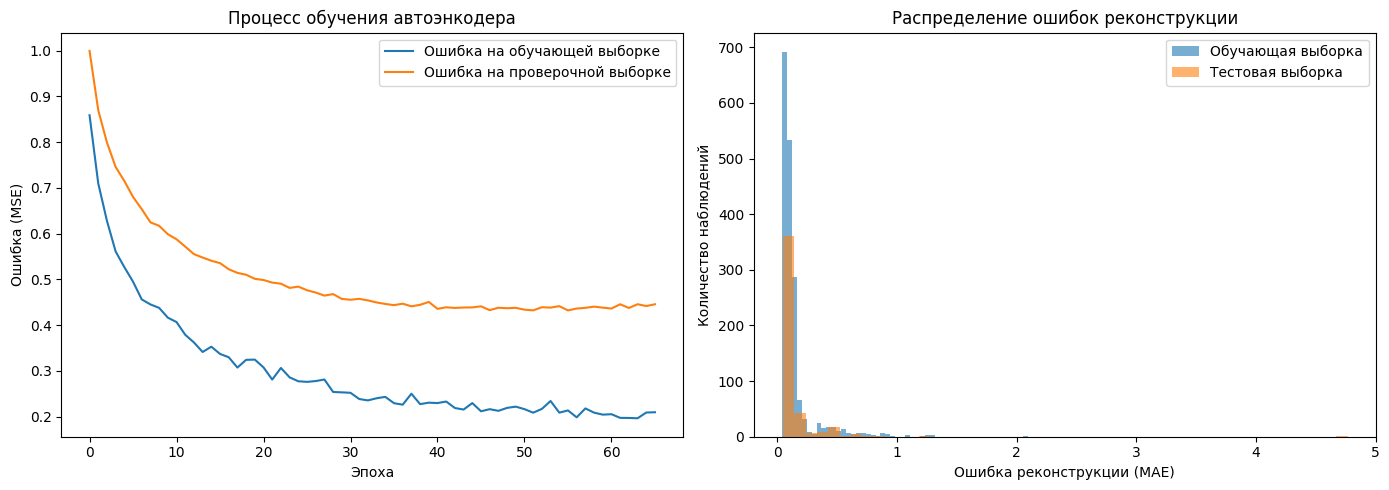

Порог обнаружения аномалий (95-й перцентиль): 0.4784
Порог обнаружения аномалий (99-й перцентиль): 0.9005


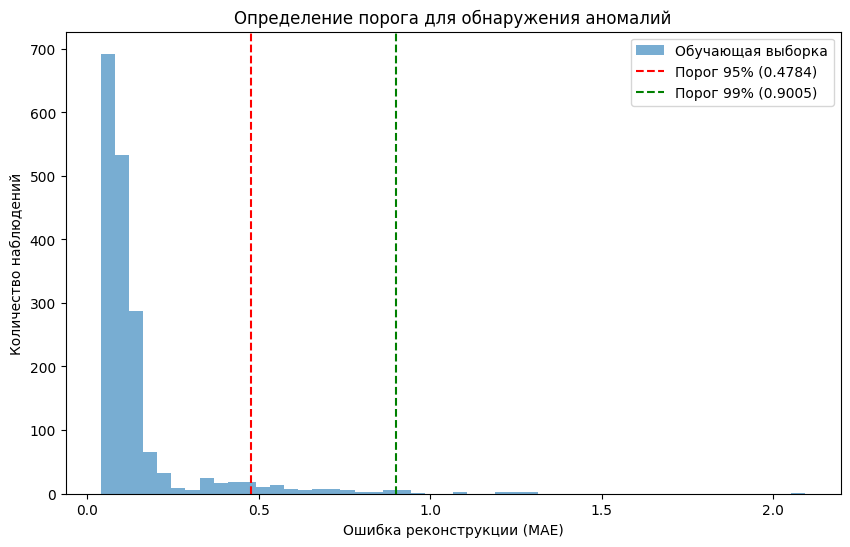

14/14 ━━━━━━━━━━━━━━━━━━━━ 2/140s 19ms/step ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


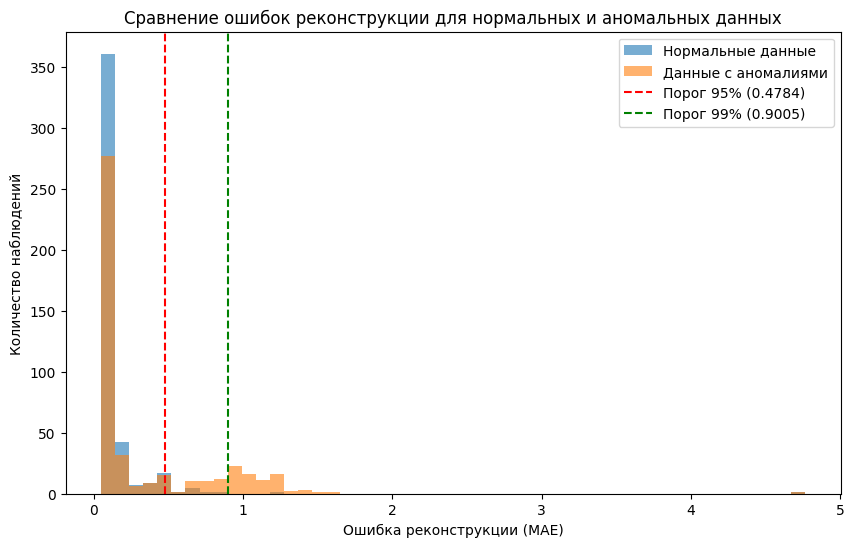


Метрики для порога 95%:
Точность (Precision): 0.8772
Полнота (Recall): 1.0000
F1-мера: 0.9346

Метрики для порога 99%:
Точность (Precision): 0.9730
Полнота (Recall): 0.7200
F1-мера: 0.8276


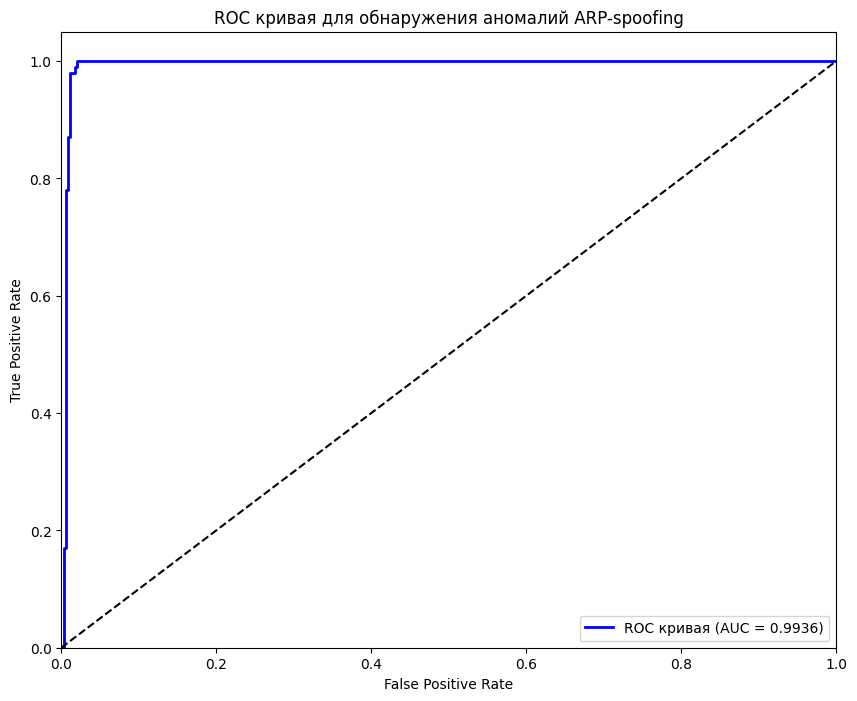

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


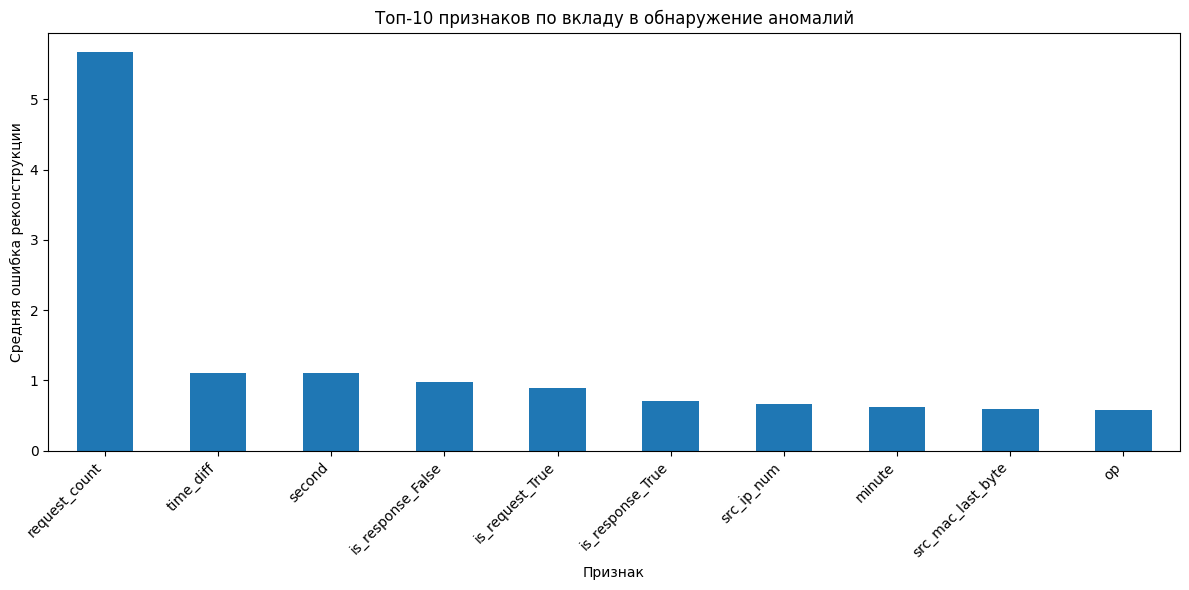


Модель и компоненты сохранены и готовы к использованию в HIDS системе.

Демонстрация обнаружения ARP-spoofing на тестовых данных:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Пакет 1: норма (оценка: 0.4303, порог: 0.4784)
Пакет 2: норма (оценка: 0.3555, порог: 0.4784)
Пакет 3: норма (оценка: 0.3624, порог: 0.4784)
Пакет 4: норма (оценка: 0.3462, порог: 0.4784)
Пакет 5: норма (оценка: 0.3454, порог: 0.4784)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.compose import ColumnTransformer

# Загрузка данных
df = pd.read_csv('arp.csv')

# Посмотрим первые несколько строк датасета
print("Первые 5 строк датасета:")
print(df.head())

# Информация о датасете
print("\nИнформация о датасете:")
print(df.info())
print("\nСтатистика датасета:")
print(df.describe())

# Проверка на пропущенные значения
print("\nПропущенные значения:")
print(df.isnull().sum())

# Предобработка данных в соответствии с структурой датасета
# Удаляем timestamp, так как у нас есть разбивка по времени (hour, minute, second)
# и столбец suspicious, так как это по сути метка, которую мы пытаемся предсказать
df_processed = df.drop(['timestamp', 'suspicious'], axis=1)

# Преобразование MAC-адресов в числовые признаки
# Один из способов - извлечь последние байты как числа
df_processed['src_mac_last_byte'] = df_processed['src_mac'].apply(lambda x: int(x.split(':')[-1], 16))
df_processed['dst_mac_last_byte'] = df_processed['dst_mac'].apply(lambda x: int(x.split(':')[-1], 16))
df_processed = df_processed.drop(['src_mac', 'dst_mac'], axis=1)

# Преобразование IP-адресов в числовые признаки
def ip_to_num(ip):
    if pd.isna(ip):
        return 0
    try:
        return sum(int(byte) * (256 ** i) for i, byte in enumerate(reversed(ip.split('.'))))
    except:
        return 0

df_processed['src_ip_num'] = df_processed['src_ip'].apply(ip_to_num)
df_processed['dst_ip_num'] = df_processed['dst_ip'].apply(ip_to_num)
df_processed = df_processed.drop(['src_ip', 'dst_ip'], axis=1)

# Обработка категориальных признаков
categorical_features = ['is_request', 'is_response']
df_processed = pd.get_dummies(df_processed, columns=categorical_features)

# Проверим результат предобработки
print("\nПосле предобработки:")
print(df_processed.head())

# Обработка пропущенных значений
# Заполнение пропущенных значений медианой для числовых признаков
df_processed['time_diff'] = df_processed['time_diff'].fillna(df_processed['time_diff'].median())

# Нормализация данных
scaler = StandardScaler()
X = scaler.fit_transform(df_processed)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Создание автоэнкодера
input_dim = X_train.shape[1]

# Размерность скрытого представления (подбираем в зависимости от размера входных данных)
encoding_dim = max(input_dim // 2, 5)  # Не менее 5 нейронов

# Входной слой
input_layer = Input(shape=(input_dim,))

# Энкодер (делаем более глубокую сеть для лучшего извлечения признаков)
encoder = Dense(input_dim)(input_layer)
encoder = LeakyReLU()(encoder)
encoder = Dropout(0.2)(encoder)
encoder = Dense(encoding_dim * 2)(encoder)
encoder = LeakyReLU()(encoder)
encoder = Dense(encoding_dim)(encoder)
encoder = LeakyReLU()(encoder)

# Декодер
decoder = Dense(encoding_dim * 2)(encoder)
decoder = LeakyReLU()(decoder)
decoder = Dropout(0.2)(decoder)
decoder = Dense(input_dim)(decoder)
decoder = LeakyReLU()(decoder)

# Полная модель автоэнкодера
autoencoder = Model(input_layer, decoder)

# Компиляция модели
autoencoder.compile(optimizer='adam', loss='mse')

# Вывод структуры модели
autoencoder.summary()

# Обучение автоэнкодера с ранней остановкой
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping],
    verbose=1
)

# График процесса обучения
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Ошибка на обучающей выборке')
plt.plot(history.history['val_loss'], label='Ошибка на проверочной выборке')
plt.title('Процесс обучения автоэнкодера')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка (MSE)')
plt.legend()

# Вычисление ошибок реконструкции
train_pred = autoencoder.predict(X_train)
train_mae = np.mean(np.abs(X_train - train_pred), axis=1)

test_pred = autoencoder.predict(X_test)
test_mae = np.mean(np.abs(X_test - test_pred), axis=1)

# Гистограмма ошибок реконструкции
plt.subplot(1, 2, 2)
plt.hist(train_mae, bins=50, alpha=0.6, label='Обучающая выборка')
plt.hist(test_mae, bins=50, alpha=0.6, label='Тестовая выборка')
plt.title('Распределение ошибок реконструкции')
plt.xlabel('Ошибка реконструкции (MAE)')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.tight_layout()
plt.show()

# Определение порога для обнаружения аномалий
# Мы используем 95-й и 99-й перцентили ошибок реконструкции на обучающей выборке
threshold_95 = np.percentile(train_mae, 95)
threshold_99 = np.percentile(train_mae, 99)

print(f"Порог обнаружения аномалий (95-й перцентиль): {threshold_95:.4f}")
print(f"Порог обнаружения аномалий (99-й перцентиль): {threshold_99:.4f}")

# Визуализация порогов на гистограмме
plt.figure(figsize=(10, 6))
plt.hist(train_mae, bins=50, alpha=0.6, label='Обучающая выборка')
plt.axvline(x=threshold_95, color='r', linestyle='--', label=f'Порог 95% ({threshold_95:.4f})')
plt.axvline(x=threshold_99, color='g', linestyle='--', label=f'Порог 99% ({threshold_99:.4f})')
plt.title('Определение порога для обнаружения аномалий')
plt.xlabel('Ошибка реконструкции (MAE)')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

# Генерация аномальных данных, симулирующих ARP-spoofing атаки
np.random.seed(42)
n_anomalies = min(100, len(X_test))
anomaly_indices = np.random.choice(len(X_test), n_anomalies, replace=False)
X_test_anomaly = X_test.copy()

# Имитация ARP-spoofing атак: 
# - Повышенное количество ARP запросов
# - Много запросов с одинаковым src_mac, но разными dst_ip
# - Маленькие значения time_diff (частые запросы)
for idx in anomaly_indices:
    # Увеличиваем request_count
    feature_indices = scaler.feature_names_in_.tolist() if hasattr(scaler, 'feature_names_in_') else range(X_test.shape[1])
    request_count_idx = feature_indices.index('request_count') if 'request_count' in feature_indices else 3
    
    # Увеличиваем значение request_count
    X_test_anomaly[idx, request_count_idx] += np.random.uniform(5, 10)
    
    # Уменьшаем time_diff (более частые запросы)
    time_diff_idx = feature_indices.index('time_diff') if 'time_diff' in feature_indices else 4
    if time_diff_idx < X_test.shape[1]:
        X_test_anomaly[idx, time_diff_idx] = max(0.01, X_test_anomaly[idx, time_diff_idx] / 10)
    
    # Добавляем случайный шум к нескольким другим признакам
    random_indices = np.random.choice(X_test.shape[1], 3, replace=False)
    X_test_anomaly[idx, random_indices] += np.random.uniform(1, 3, size=3)

# Предсказание для аномальных данных
anomaly_pred = autoencoder.predict(X_test_anomaly)
anomaly_mae = np.mean(np.abs(X_test_anomaly - anomaly_pred), axis=1)

# Визуализация распределения ошибок для нормальных и аномальных данных
plt.figure(figsize=(10, 6))
plt.hist(test_mae, bins=50, alpha=0.6, label='Нормальные данные')
plt.hist(anomaly_mae, bins=50, alpha=0.6, label='Данные с аномалиями')
plt.axvline(x=threshold_95, color='r', linestyle='--', label=f'Порог 95% ({threshold_95:.4f})')
plt.axvline(x=threshold_99, color='g', linestyle='--', label=f'Порог 99% ({threshold_99:.4f})')
plt.title('Сравнение ошибок реконструкции для нормальных и аномальных данных')
plt.xlabel('Ошибка реконструкции (MAE)')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

# Определение аномалий с использованием порога
y_pred_95 = (anomaly_mae > threshold_95).astype(int)
y_pred_99 = (anomaly_mae > threshold_99).astype(int)

# Создание истинных меток (1 для аномалий, 0 для нормальных данных)
y_true = np.zeros(len(X_test_anomaly))
y_true[anomaly_indices] = 1

# Расчет метрик
tp_95 = np.sum((y_true == 1) & (y_pred_95 == 1))
fp_95 = np.sum((y_true == 0) & (y_pred_95 == 1))
tn_95 = np.sum((y_true == 0) & (y_pred_95 == 0))
fn_95 = np.sum((y_true == 1) & (y_pred_95 == 0))

precision_95 = tp_95 / (tp_95 + fp_95) if (tp_95 + fp_95) > 0 else 0
recall_95 = tp_95 / (tp_95 + fn_95) if (tp_95 + fn_95) > 0 else 0
f1_95 = 2 * precision_95 * recall_95 / (precision_95 + recall_95) if (precision_95 + recall_95) > 0 else 0

print("\nМетрики для порога 95%:")
print(f"Точность (Precision): {precision_95:.4f}")
print(f"Полнота (Recall): {recall_95:.4f}")
print(f"F1-мера: {f1_95:.4f}")

# Для порога 99%
tp_99 = np.sum((y_true == 1) & (y_pred_99 == 1))
fp_99 = np.sum((y_true == 0) & (y_pred_99 == 1))
tn_99 = np.sum((y_true == 0) & (y_pred_99 == 0))
fn_99 = np.sum((y_true == 1) & (y_pred_99 == 0))

precision_99 = tp_99 / (tp_99 + fp_99) if (tp_99 + fp_99) > 0 else 0
recall_99 = tp_99 / (tp_99 + fn_99) if (tp_99 + fn_99) > 0 else 0
f1_99 = 2 * precision_99 * recall_99 / (precision_99 + recall_99) if (precision_99 + recall_99) > 0 else 0

print("\nМетрики для порога 99%:")
print(f"Точность (Precision): {precision_99:.4f}")
print(f"Полнота (Recall): {recall_99:.4f}")
print(f"F1-мера: {f1_99:.4f}")

# ROC-кривая
fpr, tpr, thresholds = roc_curve(y_true, anomaly_mae)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC кривая (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая для обнаружения аномалий ARP-spoofing')
plt.legend(loc="lower right")
plt.show()

# Анализ признаков с наибольшим вкладом в обнаружение аномалий
anomaly_samples = X_test_anomaly[anomaly_indices]
anomaly_reconstructions = autoencoder.predict(anomaly_samples)
reconstruction_errors = np.abs(anomaly_samples - anomaly_reconstructions)

# Средний вклад каждого признака в ошибку реконструкции
feature_errors = np.mean(reconstruction_errors, axis=0)

# Получение имен признаков для визуализации
# Если у нас нет имен признаков после преобразований, создаем их
feature_names = df_processed.columns.tolist() if hasattr(df_processed, 'columns') else [f'feature_{i}' for i in range(len(feature_errors))]

# Создание Series для удобства сортировки и визуализации
feature_importance = pd.Series(feature_errors, index=feature_names)
feature_importance = feature_importance.sort_values(ascending=False)

# Визуализация топ-10 признаков
plt.figure(figsize=(12, 6))
feature_importance.head(10).plot(kind='bar')
plt.title('Топ-10 признаков по вкладу в обнаружение аномалий')
plt.xlabel('Признак')
plt.ylabel('Средняя ошибка реконструкции')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Функция для обнаружения аномалий в новых данных
def detect_arp_spoofing(data_df, threshold=threshold_95):
    """
    Обнаружение ARP-spoofing атак в новых данных.
    
    Args:
        data_df: DataFrame с теми же колонками, что и исходный датасет
        threshold: Порог для определения аномалий
        
    Returns:
        is_anomaly: Массив булевых значений (True для аномалий)
        anomaly_scores: Значения ошибок реконструкции
    """
    # Предобработка данных так же, как и при обучении
    data_processed = data_df.drop(['timestamp', 'suspicious'], axis=1, errors='ignore')
    
    # Обработка MAC-адресов
    data_processed['src_mac_last_byte'] = data_processed['src_mac'].apply(lambda x: int(x.split(':')[-1], 16))
    data_processed['dst_mac_last_byte'] = data_processed['dst_mac'].apply(lambda x: int(x.split(':')[-1], 16))
    data_processed = data_processed.drop(['src_mac', 'dst_mac'], axis=1)
    
    # Обработка IP-адресов
    data_processed['src_ip_num'] = data_processed['src_ip'].apply(ip_to_num)
    data_processed['dst_ip_num'] = data_processed['dst_ip'].apply(ip_to_num)
    data_processed = data_processed.drop(['src_ip', 'dst_ip'], axis=1)
    
    # Обработка категориальных признаков
    categorical_features = ['is_request', 'is_response']
    data_processed = pd.get_dummies(data_processed, columns=categorical_features)
    
    # Заполнение пропущенных значений
    data_processed['time_diff'] = data_processed['time_diff'].fillna(df_processed['time_diff'].median())
    
    # Проверка на соответствие колонок
    missing_cols = set(df_processed.columns) - set(data_processed.columns)
    for c in missing_cols:
        data_processed[c] = 0
    
    # Обеспечение одинакового порядка колонок с обучающими данными
    data_processed = data_processed[df_processed.columns]
    
    # Нормализация
    data_scaled = scaler.transform(data_processed)
    
    # Предсказание
    predictions = autoencoder.predict(data_scaled)
    
    # Расчет ошибок реконструкции
    errors = np.mean(np.abs(data_scaled - predictions), axis=1)
    
    # Определение аномалий
    is_anomaly = errors > threshold
    
    return is_anomaly, errors

# Сохранение модели и важных компонентов для использования в продакшн
import joblib

# Сохранение модели
autoencoder.save('arp_spoofing_detector_model.h5')

# Сохранение скалера и других компонентов
components = {
    'scaler': scaler,
    'threshold_95': threshold_95,
    'threshold_99': threshold_99,
    'feature_columns': df_processed.columns.tolist()
}
joblib.dump(components, 'arp_spoofing_detector_components.joblib')

print("\nМодель и компоненты сохранены и готовы к использованию в HIDS системе.")

# Демонстрация использования в реальном времени
print("\nДемонстрация обнаружения ARP-spoofing на тестовых данных:")
test_sample = df.iloc[:5]  # Берем несколько строк для демонстрации
is_anomaly, scores = detect_arp_spoofing(test_sample)
for i, (anomaly, score) in enumerate(zip(is_anomaly, scores)):
    status = "АНОМАЛИЯ!" if anomaly else "норма"
    print(f"Пакет {i+1}: {status} (оценка: {score:.4f}, порог: {threshold_95:.4f})")